# Import Libraries and Create Dataset

The code imports necessary packages such as NumPy, Matplotlib, and PyTorch. The image data is loaded from the ./data directory using ImageFolder from torchvision.datasets and processed using transforms.Compose. The transformed data is then loaded into a DataLoader with a specified batch size and shuffled for training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision.utils as vutils

import matplotlib.animation as animation
from IPython.display import HTML

img_size = 128  # height and width of input images
n_noise = 64  # number of noise variables

epochs = 1201  # number of training iterations
interval = 200  # interval for displaying progress
batch_size = 128

transform = transforms.Compose([
    # transforms.Resize((img_size, img_size)).  # Resize images.
    transforms.CenterCrop(256),  # Crop center of images.
    transforms.RandomCrop(128),  # Randomly crop images.
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to [-1, 1].
])

# Set up dataset.
pets_datasets = datasets.ImageFolder(
    root = "/kaggle/input/age-recognition-dataset/Dataset", 
    transform = transform
)
print("Number of images:", len(pets_datasets))

# Set up DataLoader.
train_loader = DataLoader(
    pets_datasets, 
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

Number of images: 9097


# Visualize Sample Data

The code first extracts the next batch of images from the train_loader using next(iter(train_loader))[0]. The images are then converted to a numpy array, transposed to the (batch, height, width, channels) format, and normalized to pixel values in the range of [0, 1].

The code then specifies the number of rows and columns to display (rows and columns) as well as the display scale (scale). It then creates a figure with a size based on these parameters using plt.figure(figsize=(scale*columns, scale*rows)).

Finally, the code loops through the images and displays each one using plt.imshow. The resulting images are shown using plt.show().

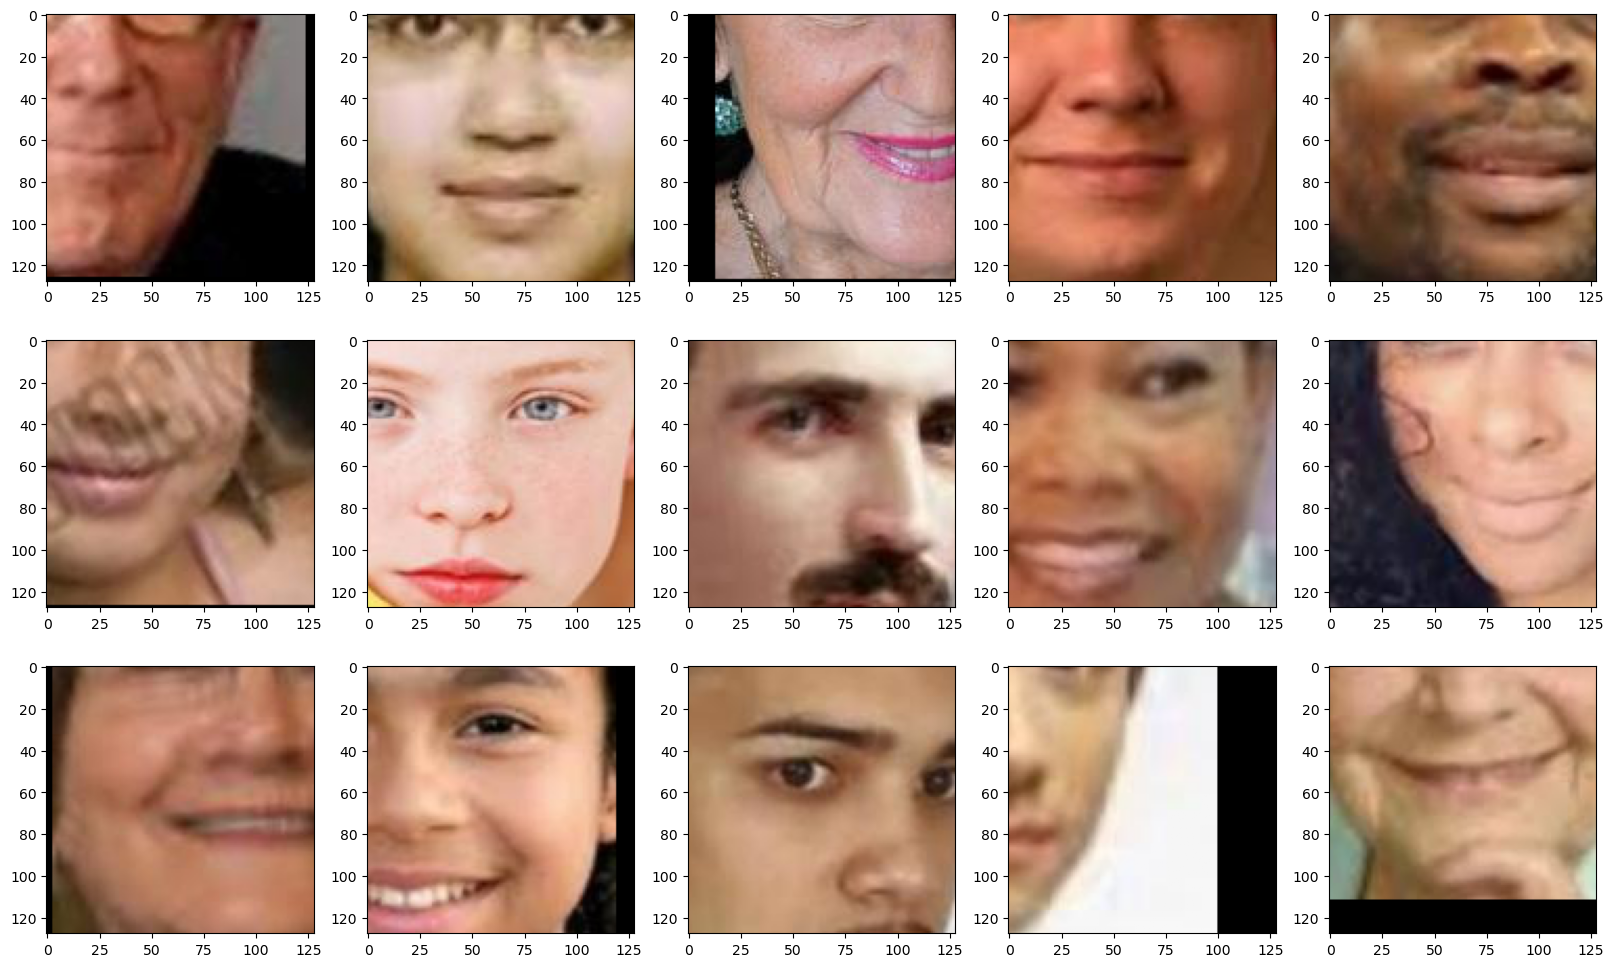

In [2]:
image = next(iter(train_loader))[0]
image = image.cpu().detach().numpy().transpose(0, 2, 3, 1)  # Change to (batch, height, width, channels) format.
image = image / 2 + 0.5  # Normalize pixel values to [0, 1].

rows = 3  # number of rows
columns = 5  # number of columns
scale = 4  # display scale
plt.figure(figsize = (scale * columns, scale * rows))

for i in range(rows * columns):
    ax = plt.subplot(rows, columns, i + 1)
    plt.imshow(image[i])
plt.show()

This code checks if there is a GPU available and decides whether to use it or the CPU. Then, it plots some training images by taking a batch of real images from the dataloader and visualizing them using Matplotlib.

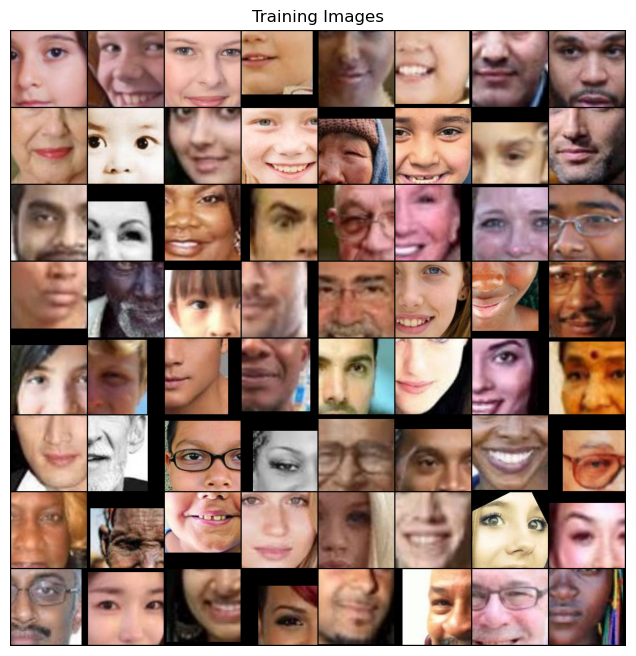

In [3]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True).cpu(),(1, 2, 0)))

# Create the Generator

The code defines a generator model using nn.Module in PyTorch. The generator takes as input a vector of noise variables x with a length of n_noise and outputs a generated image.

The generator consists of several layers of transposed convolutional neural network (ConvTranspose2d) with batch normalization and ReLU activation functions, followed by a final layer with a hyperbolic tangent activation function (Tanh) to output pixel values in the range of [-1, 1].

The forward method of the generator takes a batch of noise vectors and applies the layers to generate images. The view method is used to reshape the input noise vector to a four-dimensional tensor with the shape of (batch_size, n_noise, 1, 1) before applying the convolutional layers.

Finally, the generator is instantiated and moved to the GPU using cuda() method. The model summary is printed using print(generator).

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.ModuleList([
            # image size 1x1 → 4x4
            nn.ConvTranspose2d(n_noise, 512, 4, 1, 0),  # input channels, output channels, kernel size, stride, padding
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # image size 4x4 → 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # image size 8x8 → 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # image size 16x16 → 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # image size 32x32 → 64x64
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # image size 64x64 → 128x128
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh(),
        ])

    def forward(self, x):
        x = x.view(-1, n_noise, 1, 1)  # (batch size, channels, height, width)
        for layer in self.layers:
            x = layer(x)
        return x

generator = Generator()
generator.cuda()  # Enable GPU.
print(generator)

Generator(
  (layers): ModuleList(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): ConvTranspos

# Create the Discriminator

The code defines a discriminator model using nn.Module in PyTorch. The discriminator takes as input an image and outputs a scalar value indicating whether the input image is real or fake.

The discriminator consists of several layers of convolutional neural network (Conv2d) with batch normalization and LeakyReLU activation functions, followed by a final layer with a single output value.

The forward method of the discriminator takes a batch of images and applies the layers to output the decision values for each image. The view method is used to reshape the input images to a four-dimensional tensor with the shape of (batch_size, 3, img_size, img_size) before applying the convolutional layers.

Finally, the discriminator is instantiated and moved to the GPU using cuda() method. The model summary is printed using print(discriminator).

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList([
            # image size 128x128 → 64x64
            nn.Conv2d(3, 32, 4, 2, 1),  # Input channels, output channels, kernel size, stride, padding
            nn.LeakyReLU(negative_slope=0.2),
            # image size 64x64 → 32x32
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            # image size 32x32 → 16x16
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            # image size 16x16 → 8x8
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            # image size 8x8 → 4x4
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            # image size 4x4 → 1x1
            nn.Conv2d(512, 1, 4, 1, 0),
        ])

    def forward(self, x):
        x = x.view(-1, 3, img_size, img_size)  # (batch size, channels, height, width)
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, 1)  # (batch size, number of outputs)
        return x

discriminator = Discriminator()
discriminator.cuda()  # Enable GPU.
print(discriminator)

Discriminator(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 1,

# Generate a Batch of Images

The generate_images function generates a batch of images using the trained generator model and displays them in a grid format.

The function first creates a noise tensor with the shape of (n_rows * n_cols, n_noise) using torch.randn. The noise tensor is passed to the generator to produce a batch of generated images. The pixel values of the images are then scaled to the range of [0, 1] using g_imgs = g_imgs/2 + 0.5.

The generated images are combined into one image in a grid format using a for loop. The resulting image is displayed using plt.imshow and the axis labels and ticks are hidden using plt.tick_params.

The generate_images function can be called at regular intervals during training to visualize the training progress of the generator.

In [6]:
# -- Generate and display images. --
def generate_images(i):
    # Generate images
    n_rows = 4  # number of rows
    n_cols = 4  # number of columns
    noise = torch.randn(n_rows * n_cols, n_noise).cuda()
    g_imgs = generator(noise)
    g_imgs = g_imgs / 2 + 0.5  # Scale the pixel values to [0, 1].
    g_imgs = g_imgs.cpu().detach().numpy()

    img_size_spaced = img_size + 2
    matrix_image = np.zeros((img_size_spaced * n_rows, img_size_spaced * n_cols, 3))  # overall image

    # Combine generated images into one image.
    for r in range(n_rows):
        for c in range(n_cols):
            g_img = g_imgs[r * n_cols + c].transpose(1, 2, 0).reshape(img_size, img_size, 3)
            top = r * img_size_spaced
            left = c * img_size_spaced
            matrix_image[top : top + img_size, left : left + img_size, :] = g_img

    plt.figure(figsize = (8, 8))
    plt.imshow(matrix_image, vmin = 0.0, vmax = 1.0)
    plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)  # Hide axis labels and ticks.
    plt.show()

# Calculation for Accuracy

This is a Python function called count_correct that takes two input tensors y and t, and returns the number of correct predictions made by the discriminator model.

The function first applies a threshold to the discriminator's output y using torch.where function. The threshold is set at 0.5, such that any value less than 0.5 is set to 0 and any value greater than or equal to 0.5 is set to 1. This results in a binary tensor with the same shape as y.

The function then compares the binary tensor with the target tensor t using == operator, and counts the number of correct predictions using torch.sum. The result is then converted to a Python float using float() method and returned as a Python float using item() method.

In [7]:
def count_correct(y, t):
    correct = torch.sum((torch.where(y < 0.5, 0, 1) ==  t).float())
    return correct.item()

# Training

This is a Python script for training a DCGAN model using PyTorch.

First, it defines a loss function using nn.MSELoss(). Then, it defines two Adam optimizers for the generator and discriminator models using optim.Adam() function, with a learning rate of 0.0002, betas of (0.5, 0.999), and weight decay of 1e-5.

Next, it initializes empty lists for recording the errors and accuracies of the discriminator model on both real and fake images during the training process.

Then, it starts the training loop for the specified number of epochs, during which it iterates over the mini-batches of real images from the training data. For each mini-batch, it generates fake images using the generator model and computes the loss and accuracy for the discriminator model on both real and fake images. It then updates the parameters of the discriminator model using optimizer_disc.step() and the parameters of the generator model using optimizer_gen.step().

Finally, it computes and records the average errors and accuracies for both real and fake images for each epoch, and prints them out every interval epochs. It also calls the generate_images function to generate and display a set of fake images every interval epochs.

Epochs: 0
Error_fake: 1.14493696937441 Acc_fake: 0.569308563262614
Error_real: 0.4540491159229229 Acc_real: 0.8144443223040563


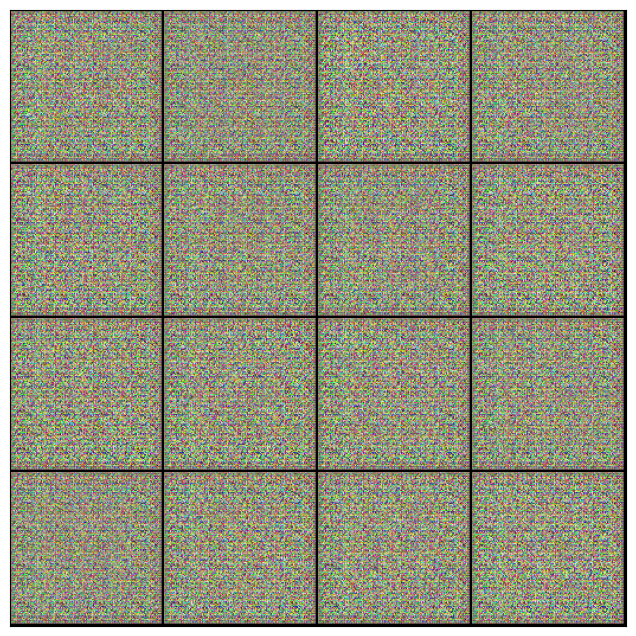

Epochs: 200
Error_fake: 0.03671943198423833 Acc_fake: 0.9851599428382983
Error_real: 0.028427177923731506 Acc_real: 0.9984610311091568


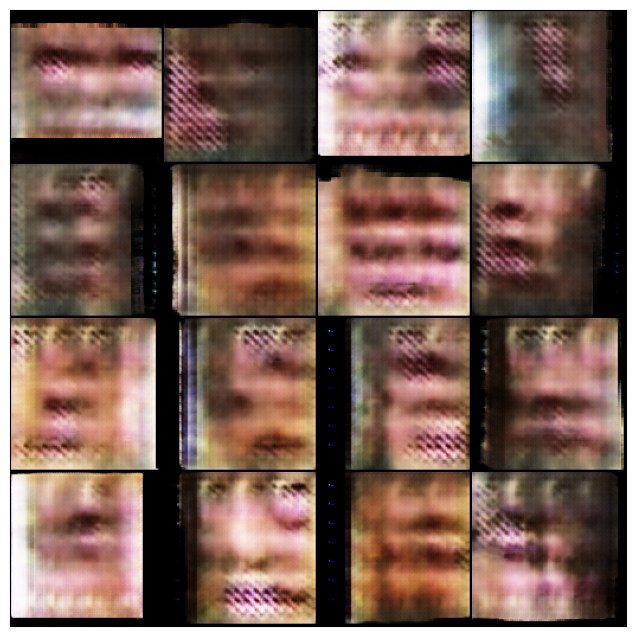

Epochs: 400
Error_fake: 0.022119887845797673 Acc_fake: 0.9987908101571947
Error_real: 0.036885052214428365 Acc_real: 0.994613608882049


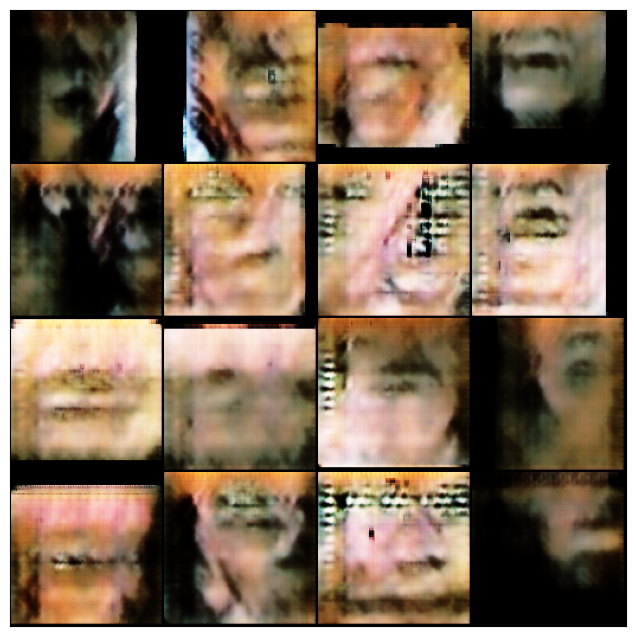

Epochs: 600
Error_fake: 0.026925362426684134 Acc_fake: 0.9936242717379355
Error_real: 0.028165100924929395 Acc_real: 0.9984610311091568


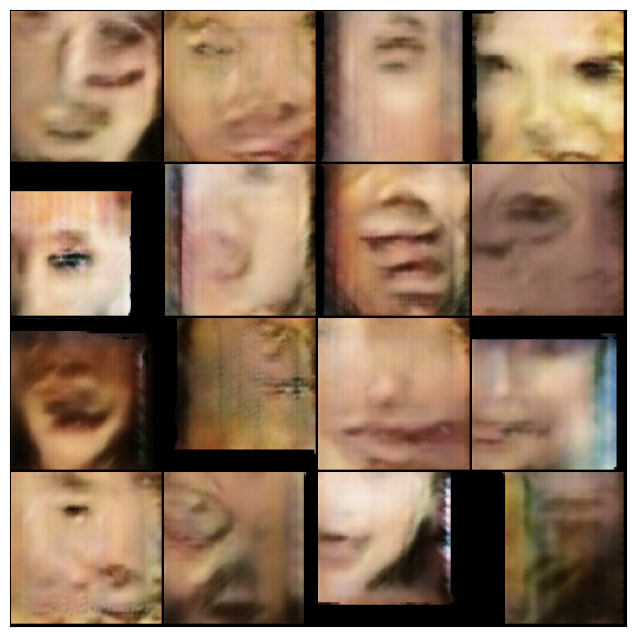

Epochs: 800
Error_fake: 0.02155501360539347 Acc_fake: 0.9985709574585028
Error_real: 0.018909703012064308 Acc_real: 0.9987908101571947


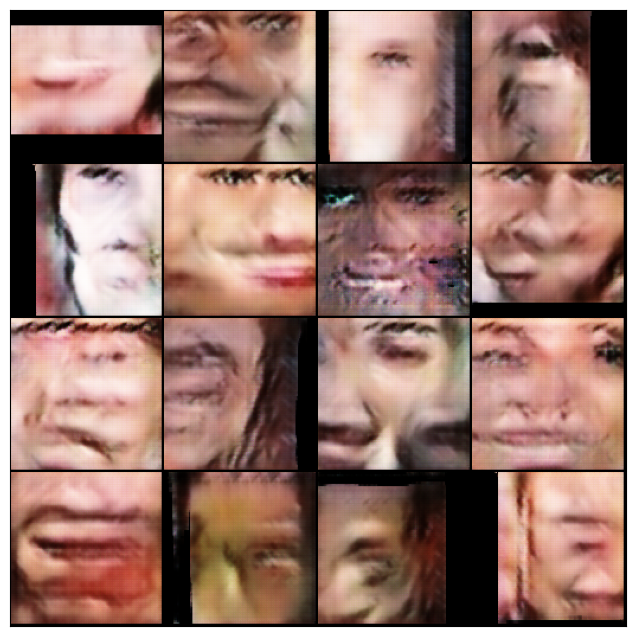

Epochs: 1000
Error_fake: 0.014737707565978376 Acc_fake: 0.9998900736506541
Error_real: 0.011782676880506592 Acc_real: 0.9994503682532703


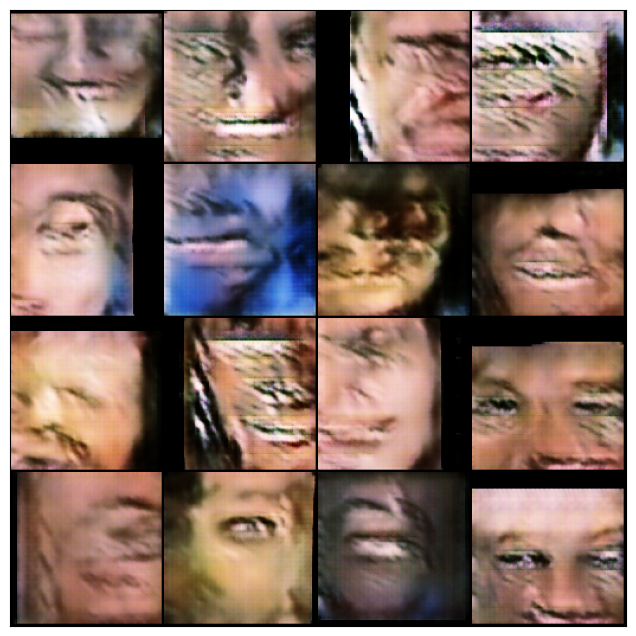

Epochs: 1200
Error_fake: 0.005605968974931683 Acc_fake: 1.0
Error_real: 0.0024101234133316516 Acc_real: 1.0


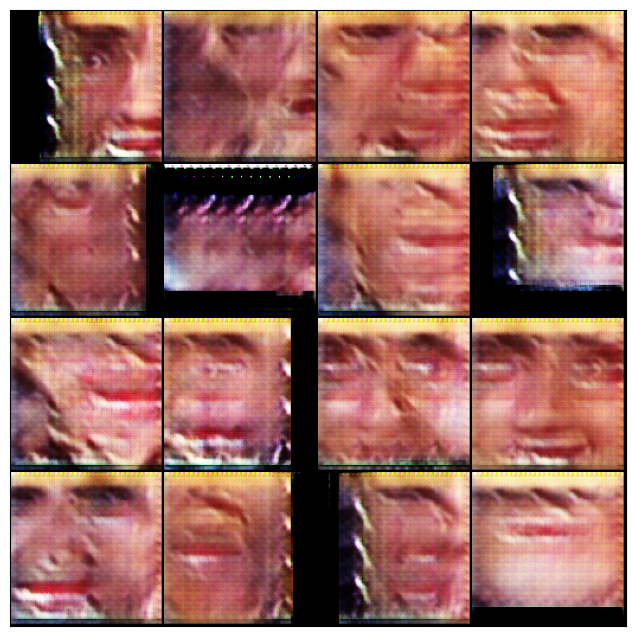

In [8]:
# Define the mean squared error (MSE) loss function using nn.MSELoss().
loss_func = nn.MSELoss()

# Define Adam optimizer for both the generator and discriminator using optim.Adam().
optimizer_gen = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999), weight_decay = 1e-5)
optimizer_disc = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999), weight_decay = 1e-5)

# Create empty lists to record error and accuracy of the generator and discriminator.
error_record_fake = []  # error for fake images
acc_record_fake = []  # accuracy for fake images
error_record_real = []  # error for real images
acc_record_real = []  # accuacy for real images

# Train the DCGAN for a specified number of epochs using a loop.
generator.train()
discriminator.train()
for i in range(epochs):
    loss_fake = 0  # error
    correct_fake = 0  # 
    loss_real = 0
    correct_real = 0
    n_total = 0  # the total number of data
    for j, (x, t) in enumerate(train_loader):  # Take mini-batches.

        n_total += x.size()[0]  # the total number of batch size

        # Generate fake images using the generator and calculate the loss and accuracy for the discriminator on these fake images.
        noise = torch.randn(x.size()[0], n_noise).cuda()
        imgs_fake = generator(noise)  # image generation
        t = torch.zeros(x.size()[0], 1).cuda()  # Correct is 0.
        y = discriminator(imgs_fake)
        loss = loss_func(y, t)
        optimizer_disc.zero_grad()
        loss.backward()
        optimizer_disc.step()  # Renew only of parameters of the Discriminator.
        loss_fake += loss.item()
        correct_fake += count_correct(y, t)

        # Train the discriminator on real images and calculate the loss and accuracy for the discriminator on these real images.
        imgs_real= x.cuda()
        t = torch.ones(x.size()[0], 1).cuda()  # Correct is 1.
        y = discriminator(imgs_real)
        loss = loss_func(y, t)
        optimizer_disc.zero_grad()
        loss.backward()
        optimizer_disc.step()  # Renew only of parameters of the Discriminator.
        loss_real += loss.item()
        correct_real += count_correct(y, t)

        # Train the generator using the discriminator's output on fake images as the ground truth and calculate the generator's loss.
        imgs_fake = generator(noise)  # image generation
        t = torch.ones(x.size()[0], 1).cuda()  # Correct is 1.
        y = discriminator(imgs_fake)
        loss = loss_func(y, t)
        optimizer_gen.zero_grad()
        loss.backward()
        optimizer_gen.step()  # Renew only of parameters of the Generator.
    
    # Calculate and record the average loss and accuracy for both the real and fake images for each epoch.
    loss_fake /= j + 1  # error
    error_record_fake.append(loss_fake)
    acc_fake = correct_fake / n_total  # accuracy
    acc_record_fake.append(acc_fake)

    loss_real /= j + 1  # error
    error_record_real.append(loss_real)
    acc_real = correct_real / n_total  # accuracy
    acc_record_real.append(acc_real)

    # Display the average loss and accuracy as well as the generated images at regular intervals.
    if i % interval == 0 or i == epochs - 1:
        print ("Epochs:", i)
        print ("Error_fake:", loss_fake , "Acc_fake:", acc_fake)
        print ("Error_real:", loss_real , "Acc_real:", acc_real)
        generate_images(i)

# Chnage in Error and Accuracy

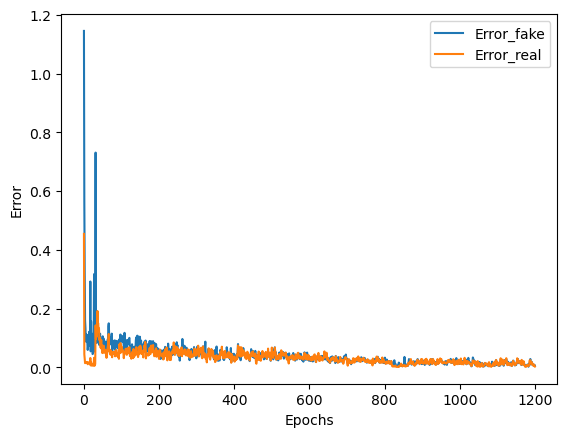

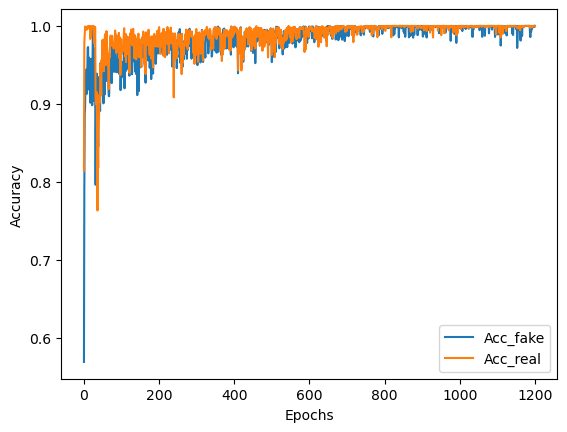

In [9]:
# change in error
plt.plot(range(len(error_record_fake)), error_record_fake, label = "Error_fake")
plt.plot(range(len(error_record_real)), error_record_real, label = "Error_real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# change in accuracy
plt.plot(range(len(acc_record_fake)), acc_record_fake, label = "Acc_fake")
plt.plot(range(len(acc_record_real)), acc_record_real, label = "Acc_real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Reference

[LSGANによる画像素材の生成](https://github.com/yukinaga/image_generation/blob/main/section_5/01_image_generation.ipynb)